In [2]:
import pandas as pd
from numpy.fft import fft, ifft,fftshift
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
#from fancyimpute import SoftImpute
import random
import time

In [2]:
def periodic_corr(x, y):
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    n1 = len(x)
    n2 = len(y)
    a = n1*[0]
    b = n2*[0]
    x = x.tolist()
    x.extend(a)
    y = y.tolist()
    y.extend(b)
    result = fftshift(ifft(fft(x) * fft(y).conj()))
    result = result.tolist()
    return result

def gaussian_filter(low_freq,high_freq,window_size,Fs):
    # % Index of low frequency and high frequency in the positive
    #% frequency domain
    ind_low = round(low_freq * window_size/ Fs) + 1
    ind_high = round(high_freq * window_size / Fs) + 1
    filter = [0]*window_size
    sigma = (ind_high - ind_low) / 6
    mean = (ind_high - ind_low) / 2
    gaussian_window = stats.norm.pdf([i+1 for i in range(ind_high - ind_low)], loc=mean, scale=sigma)
    # Positive freq part
    a = [1]*(ind_high - ind_low)
    filter[ind_low-1: ind_high - 1] = a * gaussian_window
    # Negative freq part
    filter[window_size - ind_high : window_size - ind_low] = a * gaussian_window
    return filter

In [3]:
def lag_mat(beta,lag_origin,mean_origin,sigma,delta):
    lag = [i*beta for i in lag_origin]
    window_size = 5 * 60 * 50
    '''
    low_freq = 0
    high_freq = 0.5
    Fs = 100
    filter_Y = gaussian_filter(low_freq, high_freq, window_size * 2, Fs)
    '''
    num = window_size
    length = len(lag) + 1
    mean = []
    mean.append(mean_origin)
    for i in range(length - 1):
        mean.append(mean_origin + lag[i])
    #print(mean)
    noise = []
    for i in range(length):
        noise.append(np.random.randn(num))
    data = []
    for i in range(length):
        data.append(stats.norm.pdf([t+1 for t in range(num)], loc=mean[i], scale=sigma))
    '''
    w_sigma = window_size / 2
    w_mean = window_size / 2
    gaussian_window = stats.norm.pdf([i + 1 for i in range(window_size)], loc=w_mean, scale=w_sigma)
    '''
    for i in range(length):
        data[i] = data[i] / np.max(abs(data[i])) + delta * noise[i]
    mat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            if i < j:
                Y = np.array(periodic_corr(data[i], data[j]))
                '''
                frq_Y = fft(Y)
                frq_Y = frq_Y * filter_Y
                Y_filter = ifft(frq_Y).real
                # plt.plot(Y.real)
                # num - abs(Y.real).tolist().index(max(abs(Y.real)))
                '''
                FFT = fft(Y)
                angle = np.angle(FFT[:80])
                angle_odd = [angle[2 * i + 1] for i in range(40)]
                # plt.plot(np.unwrap(angle_even))
                # plt.plot(np.unwrap(angle_odd))
                reg = linear_model.LinearRegression()
                angle_odd = np.unwrap(angle_odd)
                reg.fit(np.array([i for i in range(40)]).reshape(-1,1),angle_odd)
                mat[i, j] = reg.coef_

    for i in range(length):
        for j in range(length):
            if i > j:
                mat[i, j] = -mat[j, i]

    X = np.array([[np.exp(mat[i][j]) for j in range(len(mat[i]))] for i in range(len(mat))])
    return X

def missing_mat(X,missing_num = 5):
    length = len(X)
    y=list(range(length**2))
    slice = random.sample(y,length**2)
    missing_mask = np.reshape(slice,X.shape) < missing_num
    for i in range(length):
        missing_mask[i, i] = False
        for j in range(length):
            if missing_mask[i, j] == True:
                missing_mask[j, i] = True
    X_incomplete = X.copy()
    # missing entries indicated with NaN
    X_incomplete[missing_mask] = np.nan
    return X_incomplete

In [4]:
beta = [10,30,50]
lag_origin = [2*i+2 for i in range(7)]
mean = 7000
sigma = 100
#delta = np.sqrt([(i+1)/1000 for i in range(10)])
#delta = [(i+3)/100 for i in range(10)]
delta = [(i+1)/200 for i in range(20)]
#beta = [10]
#delta = [0.05]

In [5]:
missing_num = 4
length = len(lag_origin) + 1
y=list(range(length**2))
slice = random.sample(y,length**2)
missing_mask = np.reshape(slice,(length,length)) < missing_num
for i in range(length):
    missing_mask[i, i] = False
    for j in range(length):
        if missing_mask[i, j] == True:
            missing_mask[j, i] = True
k = np.sum(missing_mask)
print(k)
print(missing_mask)

4
[[False False  True False False False False False]
 [False False False False False False False False]
 [ True False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False  True]
 [False False False False False False  True False]]


In [6]:
#print(missing_mask)
#np.save("/home/danye/outcome/matrix_simulation_missingmask_6.npy",missing_mask)

[[False False  True False False False False False]
 [False False False False False False False False]
 [ True False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False  True]
 [False False False False False False  True False]]


In [7]:
missing_mask = np.load("/home/danye/outcome/matrix_simulation_missingmask.npy")

In [8]:
print(missing_mask)

[[False False False  True False False False  True]
 [False False False False False  True False False]
 [False False False False False False  True False]
 [ True False False False False False False False]
 [False False False False False False False False]
 [False  True False False False False False False]
 [False False  True False False False False False]
 [ True False False False False False False False]]


In [10]:
start = time.time()
#softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.005,convergence_threshold=0.0001)        
error = np.zeros((len(beta),len(delta)))
for t in range(1000):
    for i in range(len(beta)):
        X_origin = lag_mat(beta[i], lag_origin, mean, sigma, 0)
        if i == 0:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.001,convergence_threshold=0.0001)
        elif i == 1:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.003,convergence_threshold=0.0001)
        elif i == 2:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.005,convergence_threshold=0.0001)
                
        #print(X_origin[missing_mask])
        #print(1)
        for j in range(len(delta)):
            error_mat = 100000
            while error_mat/64 > 0.00001 :
                X = lag_mat(beta[i], lag_origin, mean, sigma, delta[j])
                X_incomplete = X.copy()
                X_incomplete[missing_mask] = np.nan
                #X_incomplete = missing_mat(X)
                X_filled = softimpute.complete(X_incomplete)
                #print(X[missing_mask])
                #print(X_filled[missing_mask])
                #error_mat = np.array([[(np.log(X_origin[i][j]) - np.log(X_filled[i][j])) ** 2 for j in range(len(X[i]))] for i in range(len(X))])
                #error_mat = np.sum((X_origin[missing_mask]-X_filled[missing_mask])**2)
                error_mat = np.sum((np.log(X_origin)-np.log(X_filled))**2)
                #error_mat = np.sum((np.log(X_origin)*7500/np.pi-np.log(X)*7500/np.pi)**2)
                #print(error_mat/k)
                #print(error_mat/64)
            error[i,j] = error[i,j] + error_mat/64
    print(error[0,0])
end = time.time()
print(end-start)

5.629772094514546e-09
1.1811364199318366e-08
1.910235707645695e-08
2.643499976040804e-08
3.76178707863237e-08
4.3411219509378176e-08
5.559953192715058e-08
6.313839245899167e-08
6.965774396277736e-08
7.701780092366824e-08
8.617528250431347e-08
9.799014476729495e-08
1.0428803415339434e-07
1.091360435303275e-07
1.1774065873705726e-07
1.247290586004547e-07
1.3159134792985339e-07
1.3817686134847468e-07
1.4697798941174258e-07
1.594957917158708e-07
1.6756329536431e-07
1.7772265290882166e-07
1.855029097298455e-07
1.9307640464493317e-07
2.007660240590229e-07
2.0901732235224686e-07
2.1449049318552578e-07
2.229566606160625e-07
2.2888782600219861e-07
2.354470782866111e-07
2.445574226483793e-07
2.523877758898959e-07
2.599021008972487e-07
2.7302356048925866e-07
2.784004996604859e-07
2.849156008310477e-07
2.9736799278089645e-07
3.1296455906263595e-07
3.2216036855385667e-07
3.34403409510998e-07
3.409084420164289e-07
3.4991045551499476e-07
3.5926494359065337e-07
3.660344226366944e-07
3.732183554670644e

3.1360756255046863e-06
3.1458738144593954e-06
3.153804328821535e-06
3.1647676520491005e-06
3.170836464260278e-06
3.1845318448483883e-06
3.19456539719141e-06
3.204285453391669e-06
3.2156129920410937e-06
3.221163840149028e-06
3.230780991340307e-06
3.240183246603475e-06
3.249566254779886e-06
3.261096973122317e-06
3.269772368153035e-06
3.277527300984434e-06
3.2859037166732282e-06
3.2946899879099478e-06
3.3076895781632374e-06
3.3164882427983042e-06
3.327174860134937e-06
3.3375748891738085e-06
3.3482467866020414e-06
3.355291255345986e-06
3.3606663074419917e-06
3.368006376879578e-06
3.3730478596844456e-06
3.38059518084232e-06
3.3882135730483605e-06
3.392225286049903e-06
3.4008623394127873e-06
3.4129864574459007e-06
3.42384553688119e-06
3.4331493885600944e-06
3.4405214235238664e-06
3.44940262683652e-06
3.4593572823267367e-06
3.472612181919611e-06
3.483017806215496e-06
3.49550228087435e-06
3.50158636431398e-06
3.5096709693594483e-06
3.5236491412227086e-06
3.5298676457597823e-06
3.53561270643775

6.404580813256069e-06
6.4241358643934355e-06
6.433045110741616e-06
6.44003518812199e-06
6.451470362788975e-06
6.4589483522518874e-06
6.466488725641925e-06
6.47938153727403e-06
6.487285018697969e-06
6.500418598074565e-06
6.510381203021958e-06
6.520037826266363e-06
6.536745972658658e-06
6.5421673892841075e-06
6.553086274732545e-06
6.564464260051647e-06
6.5690224273895245e-06
6.574413244794991e-06
6.58249804735467e-06
6.5891181662736325e-06
6.596952030578556e-06
6.603601842358499e-06
6.611716703501634e-06
6.618993087881922e-06
6.625893482698472e-06
6.637746569124619e-06
6.646627109893751e-06
6.654284879604535e-06
6.6654379543737465e-06
6.6734362072823145e-06
6.679050693586782e-06
6.689638358164782e-06
6.701373105185245e-06
6.70695301556541e-06
6.7179999966006085e-06
6.731664071357313e-06
6.748659489081738e-06
6.755624581427674e-06
6.7616300288144246e-06
6.771395318630708e-06
6.783913289914664e-06
6.791971133839127e-06
6.804093126457632e-06
6.810027320993899e-06
6.817482954899511e-06
6.828

In [ ]:
print(np.log(X)*75/np.pi)
print(np.log(X_incomplete)*75/np.pi)
#print(i)
#print(j)
#print(X_origin)
#print(lag_mat(beta[8], lag_origin, mean, sigma, delta[6]))
print(np.log(X_filled)*75/np.pi)
print(np.log(X)-np.log(X_filled))

In [12]:
np.save("/home/danye/outcome/matrix_simulation_error1000_103050final.npy",error)

In [ ]:
error1 = np.load('/home/danye/outcome/matrix_simulation_error1000_1050.npy')
error2 = np.load('/home/danye/outcome/matrix_simulation_error1000_2530.npy')

In [4]:
error = np.load('C:/Users/Admin/Desktop/fsdownload/matrix_simulation_error1000_103050final.npy')

In [ ]:
error_new1 = (np.sqrt(error1*49/64/1000)*7500/np.pi)
error_new2 = (np.sqrt(error2*49/64/1000)*7500/np.pi)

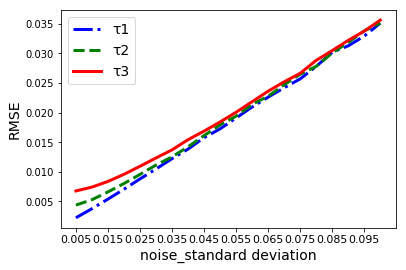

In [11]:
error_new = np.sqrt(error/1000)*75/np.pi
plt.plot(error_new[0],'-.',label = 'τ1',linewidth = 3,c = 'b')
plt.plot(error_new[1],'--',label = 'τ2',linewidth = 3,c = 'g')
plt.plot(error_new[2],label = 'τ3',linewidth = 3,c = 'r')
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('noise_standard deviation',fontsize = 14)
plt.ylabel('RMSE',fontsize = 14)
plt.xticks([2*i for i in range(10)],[(1 + 2*i)/200  for i in range(10)])
plt.legend(loc='upper left',fontsize = 14)
plt.savefig('C:/Users/Admin/Desktop/fsdownload/matrixRMSE.png')

In [ ]:
print(error)
error_new = (np.sqrt(error/100)*75/np.pi)
print(error_new)
plt.imshow(error_new[:,:], cmap='gray_r')
plt.colorbar(shrink=0.8)
plt.xlabel('noise_variance')
plt.ylabel('lag')

In [ ]:
plt.plot(error_new1[0]/100,c = 'b')#10
#plt.plot(error_new1[1]/100)
plt.plot(error_new2[0]/100,c = 'b')#2
#plt.plot(error_new2[1]/100)
plt.plot(error_new2[2]/100,c = 'b')#30
plt.xticks([2*i for i in range(10)],[i/100+0.005 for i in range(10)])
plt.xlabel('noise_standard deviation')
plt.ylabel('RMSE')
plt.savefig('/home/danye/outcome/matrix_simulation_error1000_21030.png')

In [ ]:
error100_1 = np.load("/home/danye/outcome/matrix_simulation_error100_1.npy")
error100_2 = np.load("/home/danye/outcome/matrix_simulation_error100_2.npy")
error100_3 = np.load("/home/danye/outcome/matrix_simulation_error100_3.npy")
error100_4 = np.load("/home/danye/outcome/matrix_simulation_error100_4.npy")
error100_5 = np.load("/home/danye/outcome/matrix_simulation_error100_5.npy")
error100_6 = np.load("/home/danye/outcome/matrix_simulation_error100_6.npy")
error100_7 = np.load("/home/danye/outcome/matrix_simulation_error100_7.npy")
error300_1 = np.load("/home/danye/outcome/matrix_simulation_error300_1.npy")

In [ ]:
error = error100_1 + error100_2 + error100_3 + error100_4 + error100_5 + error100_6 + error100_7 + error300_1

In [ ]:
print(error)
error_new = (np.sqrt(error/1000))
plt.imshow(error_new[:,:], cmap='gray_r')
plt.colorbar(shrink=0.8)
plt.xlabel('noise_standard deviation')
plt.ylabel('lag_beta')
plt.yticks(np.arange(0, 10, 2),[0.2,0.5,0.8,1.1,1.4])
plt.xticks(np.arange(0, 10, 2),[0.03,0.05,0.07,0.09,0.11])
#beta = [3*i + 4 for i in range(10)]
#delta = [(i+3)/100 for i in range(10)]
plt.savefig('/home/danye/outcome/matrix_simulation_error1000_final.png')

In [ ]:
window_size = 5 * 60 * 50
low_freq = 0
high_freq = 0.5
Fs = 100
filter_Y = gaussian_filter(low_freq,high_freq,window_size*2,Fs)
num = window_size


lag = [5*(i+1) for i in range(12)]
mean = [7000]
length = len(lag) + 1
for i in range(length-1):
    mean.append(mean[0] + lag[i])
sigma = 100

noise = []
for i in range(length):
    noise.append(np.random.randn(num))

data = []
for i in range(length):
    data.append(stats.norm.pdf([t+1 for t in range(num)], loc=mean[i], scale=sigma))


w_sigma = window_size / 2
w_mean = window_size / 2
gaussian_window = stats.norm.pdf([i+1 for i in range(window_size)],loc = w_mean,scale = w_sigma)
j = 0.1
for i in range(length):
    data[i] = (data[i] / np.max(abs(data[i])) + j * noise[i]) * gaussian_window

In [ ]:
mat = np.zeros((length,length))
for i in range(length):
    for j in range(length):
        if i < j:
            Y = np.array(periodic_corr(data[i],data[j]))
            frq_Y = fft(Y)
            frq_Y = frq_Y * filter_Y
            Y_filter = ifft(frq_Y).real
            # plt.plot(Y.real)
            # num - abs(Y.real).tolist().index(max(abs(Y.real)))
            FFT = fft(Y_filter)
            angle = np.angle(FFT[:80])
            angle_odd = [angle[2 * i + 1] for i in range(40)]
            # plt.plot(np.unwrap(angle_even))
            # plt.plot(np.unwrap(angle_odd))
            reg = linear_model.LinearRegression()
            angle_odd = np.unwrap(angle_odd).reshape(-1, 1)
            reg.fit(angle_odd, [i for i in range(40)])
            mat[i,j] = 1/reg.coef_

In [ ]:
print(mat)

In [ ]:
for i in range(length):
    for j in range(length):
        if i > j:
            mat[i,j] = -mat[j,i]

X = np.array([[math.exp(mat[i][j]) for j in range(len(mat[i]))] for i in range(len(mat))])
evals = abs(np.linalg.eigvals(X))
sorted_indices = np.argsort(evals)
k = 14
topk_evecs = evals[sorted_indices[:-k-1:-1]]
print(topk_evecs)
point = [i for i in range(14)]
for i in range(10):
    plt.plot([point[i],point[i]],[0,topk_evecs[i]],c = 'g')
    plt.scatter(point[i],topk_evecs[i],c = 'g')
plt.ylabel('Eigenvalue')
plt.title('Top ten largest eigenvalues')
#plt.savefig('/home/danye/outcome/eval_0.05.png')

In [ ]:
missing_mask = np.random.rand(*X.shape) < 0.05
for i in range(length):
    missing_mask[i,i] = False
    for j in range(length):
        if missing_mask[i,j] == True:
            missing_mask[j,i] = True
X_incomplete = X.copy()
# missing entries indicated with NaN
X_incomplete[missing_mask] = np.nan
print("Mean squared element: %0.4f" % (X ** 2).mean())
print(X_incomplete)

In [ ]:
softimpute = SoftImpute()
X_filled = softimpute.complete(X_incomplete)
evals = abs(np.linalg.eigvals(X_filled))
sorted_indices = np.argsort(evals)
k = 5
topk_evecs = evals[sorted_indices[:-k-1:-1]]
print(topk_evecs)
plt.plot(topk_evecs)
print(X_filled)
print(X)

In [ ]:
print(np.sum(np.isnan(X_incomplete)))
error_mat = np.array([[(X[i][j] - X_filled[i][j]) ** 2 for j in range(len(X[i]))] for i in range(len(X))])
np.sum(error_mat)/np.sum(np.isnan(X_incomplete))

In [ ]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
missing_mask = np.random.rand(*a.shape) < 0.3
a1 = a.copy()
a1[missing_mask] = np.nan

In [ ]:
X = np.array([[1.0,2,3],[3,4,5],[7,8,9]])
print(X[1,2])
X_incomplete = X.copy()
X_incomplete[1,2] = np.nan
softimpute = SoftImpute(init_fill_method = 'mean')
softimpute.complete(X_incomplete)

In [ ]:
print(X)
print(X_incomplete)
print(X[np.isnan(X_incomplete)])
print(np.sum(X[np.isnan(X_incomplete)]**3))